# 線形回帰に対するメトロポリスヘイスティングス法

「Juliaで作って学ぶベイズ統計学」P.191, 195 参照

In [1]:
using Distributions
using Plots
using ForwardDiff
using LinearAlgebra

eye(n) = Diagonal{Float64}(I, n)

eye (generic function with 1 method)

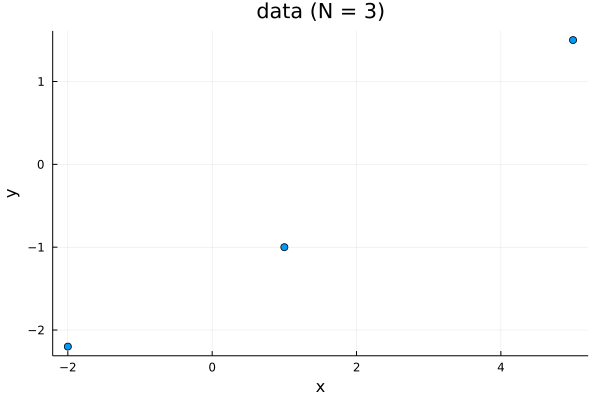

In [2]:
X_obs = [-2, 1, 5]
Y_obs = [-2.2, -1.0, 1.5]
scatter(X_obs, Y_obs, xlab="x", ylab="y",
        label=:none, title="data (N = $(length(X_obs)))")

In [3]:
σ = 1.0
μ₁ = 0.0
μ₂ = 0.0
σ₁ = 10.0
σ₂ = 10.0;

In [4]:
log_joint(w, X, Y, σ, μ₁, σ₁, μ₂, σ₂) =
    sum(logpdf.(Normal.(w[1] * X .+ w[2], σ), Y)) +
    logpdf(Normal(μ₁, σ₁), w[1]) +
    logpdf(Normal(μ₂, σ₂), w[2])
ulp(w) = log_joint(w, params...)

ulp (generic function with 1 method)

In [5]:
params = (X_obs, Y_obs, σ, μ₁, σ₁, μ₂, σ₂)
w_init = randn(2)

2-element Vector{Float64}:
 -0.8888042004525395
 -1.0705562550744832

In [6]:
function gaussian_gmh(log_p_tilde, μ₀, maxiter, σ)
    D = length(μ₀)
    μ_samples = Array{typeof(μ₀[1]), 2}(undef, D, maxiter)
    μ_samples[:, 1] = μ₀
    num_accepted = 1
    for i in 2:maxiter
        μ_tmp = rand(MvNormal(μ_samples[:, i-1], σ * eye(D)))
        log_r = (log_p_tilde(μ_tmp) +
                logpdf(MvNormal(μ_tmp, σ), μ_samples[:, i-1])) -
                (log_p_tilde(μ_samples[:, i-1]) +
                logpdf(MvNormal(μ_samples[:, i-1], σ), μ_tmp))
        is_accepted = min(1, exp(log_r)) > rand()
        new_sample = is_accepted ? μ_tmp : μ_samples[:, i-1]
        μ_samples[:, i] = new_sample
        num_accepted += is_accepted
    end
    μ_samples, num_accepted
end

function inference_wrapper_gmh(log_joint, params, w_init, maxiter, σ)
    ulp(w) = log_joint(w, params...)
    gaussian_gmh(ulp, w_init, maxiter, σ)
end

inference_wrapper_gmh (generic function with 1 method)

In [7]:
maxiter = 300
param_posterior_gmh, num_accepted_gmh = inference_wrapper_gmh(log_joint, params, w_init, maxiter, σ)

([-0.8888042004525395 -0.8888042004525395 … 0.5492053940720316 0.5492053940720316; -1.0705562550744832 -1.0705562550744832 … -0.7229124116846626 -0.7229124116846626], 49)

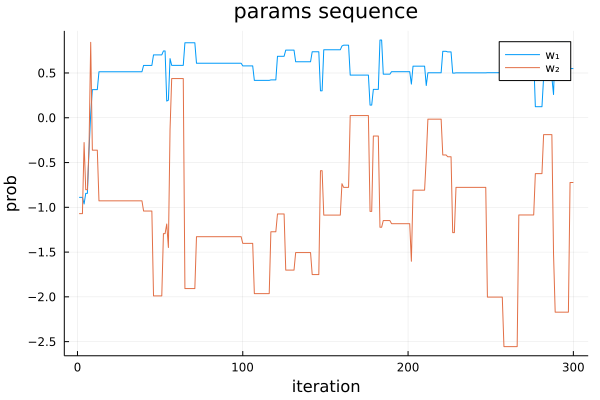

In [8]:
plot(param_posterior_gmh[1, :], xlab="iteration", ylab="prob", title="params sequence", label="w₁")
plot!(param_posterior_gmh[2, :], xlab="iteration", ylab="prob", title="params sequence", label="w₂")

In [9]:
w₁s = range(-5, 5, length=100)
w₂s = range(-5, 5, length=100);

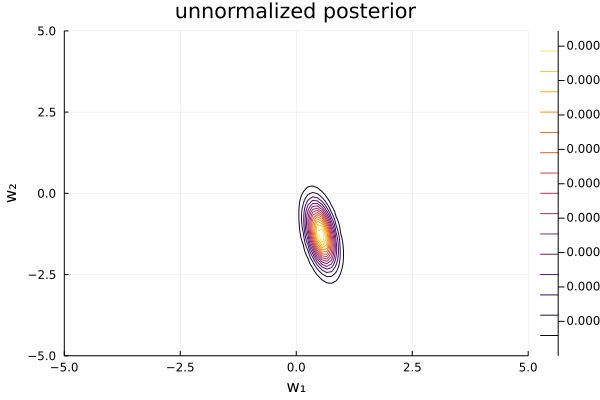

In [10]:
contour(w₁s, w₂s, [exp(ulp([w₁, w₂])) for w₁ in w₁s, w₂ in w₂s]',
        xlab="w₁", ylab="w₂", title="unnormalized posterior")

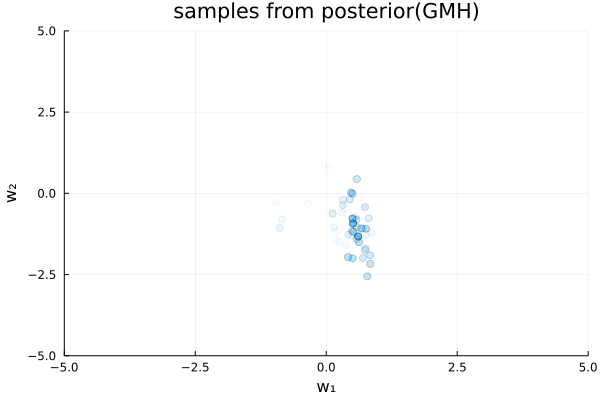

In [11]:
scatter(param_posterior_gmh[1, :], param_posterior_gmh[2, :], alpha=10/maxiter,
        xlim=(-5,5), ylim=(-5,5), xlab="w₁", ylab="w₂", title="samples from posterior(GMH)", label=:none)

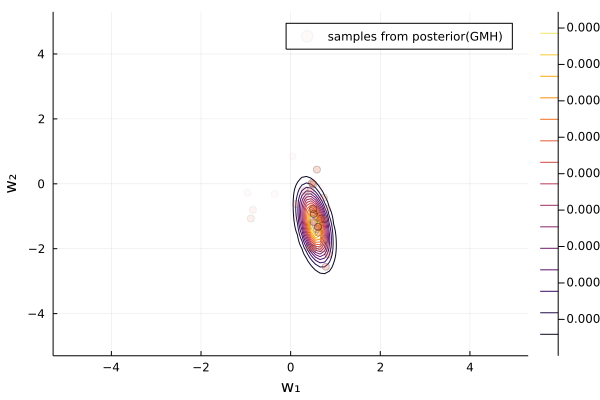

In [12]:
contour(w₁s, w₂s, [exp(ulp([w₁, w₂])) for w₁ in w₁s, w₂ in w₂s]', xlab="w₁", ylab="w₂")
scatter!(param_posterior_gmh[1, :], param_posterior_gmh[2, :], alpha=10/maxiter,
         xlab="w₁", ylab="w₂", label="samples from posterior(GMH)")

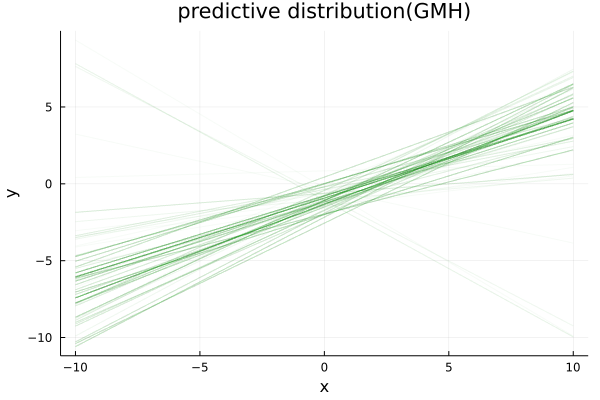

In [13]:
xs = range(-10, 10, length=100)
p = plot(xlab="x", ylab="y", title="predictive distribution(GMH)")
for i in 1:size(param_posterior_gmh, 2)
    w₁, w₂ = param_posterior_gmh[:, i]
    f(x) = w₁ * x + w₂
    p = plot!(xs, f.(xs), linecolor=:green, alpha=10/maxiter, label=:none)
end
p